In [1]:
from IPython.display import display, Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

In [2]:
from LagsCreator import LagsCreator

In [3]:
data = np.array([[np.nan, 2, np.nan, np.nan, np.nan, np.nan, np.nan, 4, np.nan, np.nan, np.nan, np.nan, np.nan, 6, np.nan, 2, np.nan, np.nan, np.nan, np.nan, np.nan, 4, np.nan, np.nan, np.nan, np.nan, np.nan, 6], 
                 [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 
                 [3]*28])

In [4]:
np.random.seed(42)
data = np.random.rand(3, 28)

In [5]:
df = pd.DataFrame(np.transpose(data), index = pd.date_range("2018-08-22", periods = data.shape[1]), columns = pd.MultiIndex.from_product([["Group 1"], ["A", "B", "C"]], names = ["Group", "Time-series"]))

In [6]:
df["Group 1"]

Time-series,A,B,C
2018-08-22,0.374540,0.592415,0.088493
2018-08-23,0.950714,0.046450,0.195983
2018-08-24,0.731994,0.607545,0.045227
2018-08-25,0.598658,0.170524,0.325330
2018-08-26,0.156019,0.065052,0.388677
2018-08-27,0.155995,0.948886,0.271349
2018-08-28,0.058084,0.965632,0.828738
2018-08-29,0.866176,0.808397,0.356753
2018-08-30,0.601115,0.304614,0.280935
2018-08-31,0.708073,0.097672,0.542696


In [7]:
lags_dict = dict()
# Define lags for each indicator.
lags_dict["A"] = np.array([1, 3])
lags_dict["B"] = np.array([1, 2, 3, 5])
lags_dict["C"] = np.array([1])

In [8]:
t1=time.time()
creator = LagsCreator(df["Group 1"], lags_dict, "B") 
t2=time.time()
print(t2-t1)

0.012966156005859375


In [9]:
t1=time.time()
X_train, y_train, X_test, columns_input = creator.to_supervised(h = 2, step = 1, single_step = True, return_dataframe = True,
                                                               feature_time = ["Day", "Month", "Year"])
t2=time.time()
print(t2-t1)

0.004025459289550781


In [10]:
X_train

Features          A                     B                                   \
Lags         x(t-2)       x(t)     x(t-4)     x(t-2)     x(t-1)       x(t)   
0          0.731994   0.156019   0.592415   0.607545   0.170524  0.0650516   
1          0.598658   0.155995  0.0464504   0.170524  0.0650516   0.948886   
2          0.156019  0.0580836   0.607545  0.0650516   0.948886   0.965632   
3          0.155995   0.866176   0.170524   0.948886   0.965632   0.808397   
4         0.0580836   0.601115  0.0650516   0.965632   0.808397   0.304614   
5          0.866176   0.708073   0.948886   0.808397   0.304614  0.0976721   
6          0.601115  0.0205845   0.965632   0.304614  0.0976721   0.684233   
7          0.708073    0.96991   0.808397  0.0976721   0.684233   0.440152   
8         0.0205845   0.832443   0.304614   0.684233   0.440152   0.122038   
9           0.96991   0.212339  0.0976721   0.440152   0.122038   0.495177   
10         0.832443   0.181825   0.684233   0.122038   0.495177  0.0343885   
11         0.212339   0.183405   0.440152   0.495177  0.0343885    0.90932   
12         0.181825   0.304242   0.122038  0.0343885    0.90932    0.25878   
13         0.183405   0.524756   0.495177    0.90932    0.25878   0.662522   
14         0.304242   0.431945  0.0343885    0.25878   0.662522   0.311711   
15         0.524756   0.291229    0.90932   0.662522   0.311711   0.520068   
16         0.431945   0.611853    0.25878   0.311711   0.520068    0.54671   
17         0.291229   0.139494   0.662522   0.520068    0.54671   0.184854   
18         0.611853   0.292145   0.311711    0.54671   0.184854   0.969585   
19         0.139494   0.366362   0.520068   0.184854   0.969585   0.775133   
20         0.292145    0.45607    0.54671   0.969585   0.775133   0.939499   
21         0.366362   0.785176   0.184854   0.775133   0.939499   0.894827   

Features           C    Day  Month   Year  
Lags            x(t) x(t+2) x(t+2) x(t+2)  
0           0.388677     28      8   2018  
1           0.271349     29      8   2018  
2           0.828738     30      8   2018  
3           0.356753     31      8   2018  
4           0.280935      1      9   2018  
5           0.542696      2      9   2018  
6           0.140924      3      9   2018  
7           0.802197      4      9   2018  
8          0.0745506      5      9   2018  
9           0.986887      6      9   2018  
10          0.772245      7      9   2018  
11          0.198716      8      9   2018  
12        0.00552212      9      9   2018  
13          0.815461     10      9   2018  
14          0.706857     11      9   2018  
15          0.729007     12      9   2018  
16           0.77127     13      9   2018  
17         0.0740447     14      9   2018  
18          0.358466     15      9   2018  
19          0.115869     16      9   2018  
20          0.863103     17      9   2018  
21          0.623298     18      9   2018

In [11]:
y_train

Target,B
Prediction horizon,x(t+2)
0,0.965632
1,0.808397
2,0.304614
3,0.0976721
4,0.684233
5,0.440152
6,0.122038
7,0.495177
8,0.0343885


In [12]:
X_test

Features         A                   B                                      C  \
Lags        x(t-2)      x(t)    x(t-4)    x(t-2)  x(t-1)      x(t)       x(t)   
0         0.785176  0.514234  0.775133  0.894827  0.5979  0.921874  0.0635584   

Features    Day  Month   Year  
Lags     x(t+2) x(t+2) x(t+2)  
0            20      9   2018

In [13]:
train, test = creator.visualization(boundaries = False, gif = True)

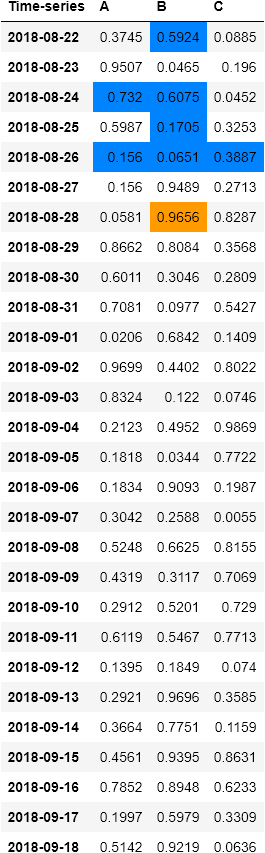

In [14]:
with open("./visualization/GIF.gif", "rb") as f:
    display(Image(data = f.read(), format = "png", width = 150))

In [15]:
train[2]

Time-series,A,B,C
2018-08-22,0.3745,0.5924,0.0885
2018-08-23,0.9507,0.0465,0.196
2018-08-24,0.732,0.6075,0.0452
2018-08-25,0.5987,0.1705,0.3253
2018-08-26,0.156,0.0651,0.3887
2018-08-27,0.156,0.9489,0.2713
2018-08-28,0.0581,0.9656,0.8287
2018-08-29,0.8662,0.8084,0.3568
2018-08-30,0.6011,0.3046,0.2809
2018-08-31,0.7081,0.0977,0.5427
